# NEMO upwelling results postprocessing

***

In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import geo_tools, viz_tools
from dynmodes import dynmodes
from warnings import simplefilter

%matplotlib inline
simplefilter('ignore')

In [21]:
plt.rcParams['font.size'] = 12

***

## Load netCDF files and define global parameters

In [22]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50

***

## Coastline indices

   * Find the j, i coastline indices for transects along the SoG portion of the domain
   * Determine the coastline angle and bottom slope
   
Define functions

In [4]:
def calc_coastline_indices(mask, bathy, e1t=440):
    """
    """

    # Indexing parameters
    imin, jmin, jmax, jsub = 115, 365, 745, 5
    winlen = 15

    # Initialize index array and seed deep landpoint index
    index = np.empty(0, dtype=int)
    i_d_prev = 200

    # Iterate through jindex
    for j in range(jmin-winlen, jmax+winlen):

        # Extract surface and deep mask rows
        i_s = np.where(abs(np.diff(mask.tmask[0, 0, j, imin:])) > 0)[0]
        i_d = np.where(abs(np.diff(mask.tmask[0, 29, j, imin:])) > 0)[0]

        # Remove discontinuous deep land points (i.e., Gulf Island basins)
        while abs(i_d[0] - i_d_prev) > 30: i_d = i_d[1:]
        i_d_prev = i_d[0]

        # Append coastline point to array
        index = np.append(index, i_s[i_s < i_d[0]][-1] + imin)

    # Find coastline angle from smoothed coastline index
    window = signal.get_window('blackman', 2*winlen+1)
    angle = np.arctan(np.diff(signal.convolve(index, window / sum(window), mode='same')))

    # Populate sections dict
    sections = {
        'ji': [np.arange(jmin, jmax, jsub), index[winlen:-winlen:jsub]],
        'angle': angle[winlen:-winlen:jsub],
    }

    # Calculate bottom slope
    bottom = np.empty((0, 50))
    for j, i in zip(*sections['ji']):
        bottom = np.concatenate((bottom, bathy[j, i:i+50].values[np.newaxis, :]))
    bottom[bottom > 200] = 200
    sections['slope'] = np.nanmax(bottom, axis=1) / np.cos(sections['angle']) / np.nanargmax(bottom, axis=1) / e1t
        
    return sections, bottom


def calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS):
    """
    """
    
    # Initialize index arrays and define search tolerances
    sections['ji_HRDPS'] = [np.empty(0, dtype=int), np.empty(0, dtype=int)]
    tols = {
        'NEMO'  : {'tol_lon': 0.010, 'tol_lat': 0.003},
        'GEM2.5': {'tol_lon': 0.017, 'tol_lat': 0.017},
    }
    
    # Loop through NEMO coastline indices
    for j, i in zip(*sections['ji']):
        
        # Search for nearest lon/lat neighbors
        jj, ii = geo_tools.find_closest_model_point(
            mask.glamt[0, j, i].values, mask.gphit[0, j, i].values,
            grid_HRDPS.longitude-360, grid_HRDPS.latitude,
            grid='GEM2.5', tols=tols,
        )
        
        # Append new values to indices
        for dim, val in zip([0, 1], [jj, ii]):
            sections['ji_HRDPS'][dim] = np.append(sections['ji_HRDPS'][dim], val)
        
    return sections

Call functions to build coastline indices

In [5]:
# Build coastline index arrays
sections, bottom = calc_coastline_indices(mask, bathy.Bathymetry)
sections = calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS)

Plot coastline indices

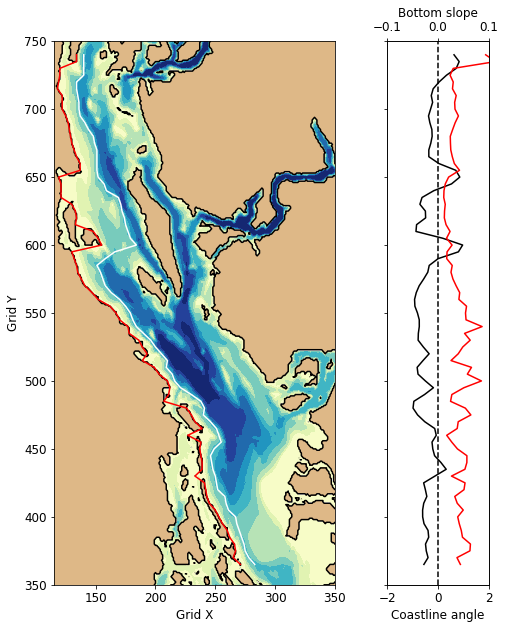

In [6]:
# Plot NEMO coastline and bathymetry
fig, axs = plt.subplots(1, 2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})
axs[0].set_xlim([115, 350])
axs[0].set_ylim([350, 750])
axs[0].contourf(bathy.Bathymetry, levels=range(0, 451, 50), cmap='YlGnBu', extend='both')
axs[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
axs[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
axs[0].plot(*sections['ji'][::-1], 'r-')
axs[0].plot(sections['ji'][1]+np.nanargmax(bottom, axis=1), sections['ji'][0], 'w-')
axs[0].set_xlabel('Grid X')
axs[0].set_ylabel('Grid Y')
viz_tools.set_aspect(axs[0])

# Plot coastline angle
axs[1].plot([0, 0], [350, 750], 'k--')
axs[1].plot(sections['angle'], sections['ji'][0], 'k-')
axs[1].set_xlim([-2, 2])
axs[1].set_ylim([350, 750])
axs[1].yaxis.set_ticklabels('')
axs[1].set_xlabel('Coastline angle')

# Plot bottom slope
ax2 = axs[1].twiny()
ax2.plot(sections['slope'], sections['ji'][0], 'r-')
ax2.set_xlim([-0.1, 0.1])
ax2.set_xlabel('Bottom slope')
plt.show()

***

## Load NEMO runs

Universal functions

In [23]:
def calc_rho(data, depth, tmask):
    """Calculate the density, rho
    """
    
    tracers = ['vosaline', 'votemper']
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)
    
    return rho

***

### Idealized - 2 layer

Functions specific to idealized processing

In [8]:
def calc_idealized_upwelling_metrics(data, mask, hour, j, i, z_ref, jsub=0, isub=0, angle=0, L=50):
    """
    """
    
    # Extract deptht array
    deptht = mask.gdept_1d[0, :].values
    
    # Calculate stratification parameters
    rho_t0 = calc_rho(
        data.isel(time_counter=0, y=j-jsub, x=slice(i-isub, None)),
        np.expand_dims(deptht, axis=1), mask.tmask[0, :, j, i:],
    )
    rho_ref = rho_t0[abs(deptht - z_ref).argmin(axis=0), :L].mean()

    # Calculate upwelling metrics
    rho = calc_rho(
        data.isel(time_counter=hour, deptht=0, y=j-jsub, x=slice(i-isub, None)),
        0, mask.tmask[0, 0, j, i:],
    )
    rho_max = rho[:L].max()
    z_u = deptht[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0)))]
    x_u = np.cos(angle) * (rho >= rho_ref).sum() * float(mask.e1t[0, j, i])
            
    return z_u, x_u


def process_idealized_results_2layer(
    param, sections, mask, grids, hour=24, L=50,
    path='/data/bmoorema/results/Lake/S4d',
    fn='SalishSeaIdeal_1h_20170701_20170706_grid_T.nc',
):
    """
    """
    
    # Initialize runs dict
    runs = {}
    
    # Loop through run parameters and define dict fields
    for z_h in tqdm(param['z_h']):
        runs[z_h] = {}
        for rho_s in param['rho_surf']:
            runs[z_h][rho_s] = {}
            for U in param['u_wind']:
                runs[z_h][rho_s][U] = {'z_u': [], 'x_u': []}

                # Define and load results file
                runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
                file = os.path.join(path, runID, fn)
                if os.path.exists(file):
                    with xr.open_dataset(file) as data:

                        # Loop through sections
                        for j, i, a in zip(*sections['ji'], sections['angle']):

                            # Calculate upwelling metrics
                            z_u, x_u = calc_idealized_upwelling_metrics(
                                data, mask, hour, j, i, z_h, angle=a, L=L,
                                jsub=grids['ideal'][2], isub=grids['ideal'][0],
                            )
                            runs[z_h][rho_s][U]['z_u'].append(z_u)
                            runs[z_h][rho_s][U]['x_u'].append(x_u)

    return runs

Process idealized 2-layer results

In [9]:
# Process idealized 2-layer results
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}
runs = process_idealized_results_2layer(param, sections, mask, grids)

Plot idealized 2-layer results

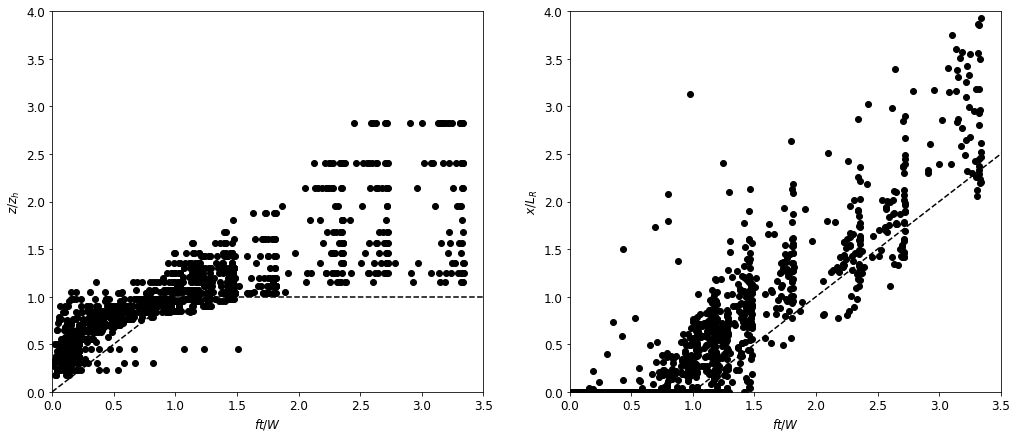

In [7]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)

# Define tau j component
jtau = np.sin(np.arctan(2) - sections['angle']) * (hour - 3) * 3600

# Loop through run parameters
for z_h in param['z_h']:
    for rho_s in param['rho_surf']:
        for U, tau in zip(param['u_wind'], param['tau']):
            
            # Define upwelling predictor ft/W
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            L_R = np.sqrt(g_prime * z_h) / const['f']
            ftW = tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
            
            # Plot predictions vs results
            for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
                ax.plot(ftW, np.array(runs[z_h][rho_s][U][var]) / scale, 'ko')

***

### Hindcast - 2 layer

Functions specific to hindcast processing

In [71]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix


def calc_hindcast_upwelling_metrics_t0(data, mask, time, j, i, const, L=50):
    """
    """

    # Construct depth arrays
    deptht = mask.gdept_1d[0, :].values
    deptht2d = np.expand_dims(deptht, axis=1)
    depthw = (deptht[1:] + deptht[:-1]) / 2
    
    # Calculate density
    rho_t0 = calc_rho(
        data.sel(time_counter=time, method='nearest').isel(y=j, x=slice(i, None)),
        deptht2d, mask.tmask[0, :, j, i:],
    )
    
    # Calculate pycnocline depth using vertical mode calculator dynmodes
    N2 = const['g'] / const['rho_0'] * np.diff(rho_t0, axis=0) / np.diff(deptht2d, axis=0)
    N2 = np.ma.median(N2[:, :L], axis=1).compressed()
    zlim = min(len(N2), 24)
    modes = dynmodes(N2[:zlim], depthw[:zlim], 1)
    z_h = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
    
    # Find surface and interface densities
    rho_s = rho_t0[:int(z_h), :L].mean()
    rho_ref = rho_t0[abs(deptht - z_h).argmin(axis=0), :L].mean()
    
    return z_h, rho_s, rho_t0, rho_ref


def calc_hindcast_upwelling_metrics_t1(data, mask, timerange, j, i, HRDPS, jj, ii, rho_t0, rho_ref, angle=0, L=50):
    """
    """

    # Construct depth arrays
    deptht = mask.gdept_1d[0, :].values
    
    # Calculate tau
    u, v = [
        HRDPS.sel(time=slice(*timerange))[k].values[:, jj, slice(ii, ii+10)]
        for k in ['u_wind', 'v_wind']
    ]
    jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180) + angle)
    tau = sum(1.225e-3 * (jtau * np.sqrt(u**2 + v**2)).mean(axis=1)**2) * 3600

    # Calculate upwelling metrics
    rho = calc_rho(
        data.sel(time_counter=timerange[1], method='nearest').isel(deptht=0, y=j, x=slice(i, None)),
        0, mask.tmask[0, 0, j, i:],
    )
    rho_max = rho[:L].max()
    z_u = deptht[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0)))]
    x_u = np.cos(angle) * (rho[:L].compressed() >= rho_ref).sum() * float(mask.e1t[0, j, i])
    
    return z_u, x_u, tau


def process_hindcast_results(
    dates, sections, mask, HRDPS, hour=24, L=50,
    const={'g': 9.81, 'rho_0': 1e3},
    path='/results2/SalishSea/nowcast-green.201812',
):
    """
    """
    
    # Initialize runs dict
    runs = {}
    
    # Loop through upwelling event dates
    for date in tqdm(dates):
        
        # Define date objects and dict subfields
        dateobj = parse(date)
        datestr = dateobj.strftime('%Y%b%d')
        runs[datestr] = {'date': dateobj, 'rho_s': [], 'z_h': [], 'tau': [], 'z_u': [], 'x_u': []}
        variables = {'rho_t0': [], 'rho_ref': []}

        # Loop through hours
        for hour in [0, hour]:
            time = dateobj + timedelta(hours=hour)

            # Open hindcast record
            with xr.open_dataset(make_prefix(time, path) + '_grid_T.nc') as data:

                # Loop through sections
                for n, j, i, jj, ii, a in zip(
                    range(len(sections['ji'][0])), *sections['ji'], *sections['ji_HRDPS'], sections['angle'],
                ):

                    # Calculations at t=0
                    if hour == 0:

                        # Calculate stratification parameters
                        z_h, rho_s, rho_t0, rho_ref = calc_hindcast_upwelling_metrics_t0(
                            data, mask, time, j, i, const, L=L,
                        )

                        # Append to dict lists
                        runs[datestr]['z_h'].append(z_h)
                        runs[datestr]['rho_s'].append(rho_s)
                        variables['rho_t0'].append(rho_t0)
                        variables['rho_ref'].append(rho_ref)

                    # Calculations at hours
                    else:

                        # Calculate upwelling parameters
                        z_u, x_u, tau = calc_hindcast_upwelling_metrics_t1(
                            data, mask, [dateobj, time], j, i, HRDPS, jj, ii,
                            variables['rho_t0'][n], variables['rho_ref'][n], angle=a, L=L,
                        )

                        # Append to dict lists
                        runs[datestr]['z_u'].append(z_u)
                        runs[datestr]['x_u'].append(x_u)
                        runs[datestr]['tau'].append(tau)
                        
    return runs

Process hindcast results

In [72]:
# Process hindcast results
runs = process_hindcast_results(events_southerly, sections, mask, HRDPS)

Plot hindcast results

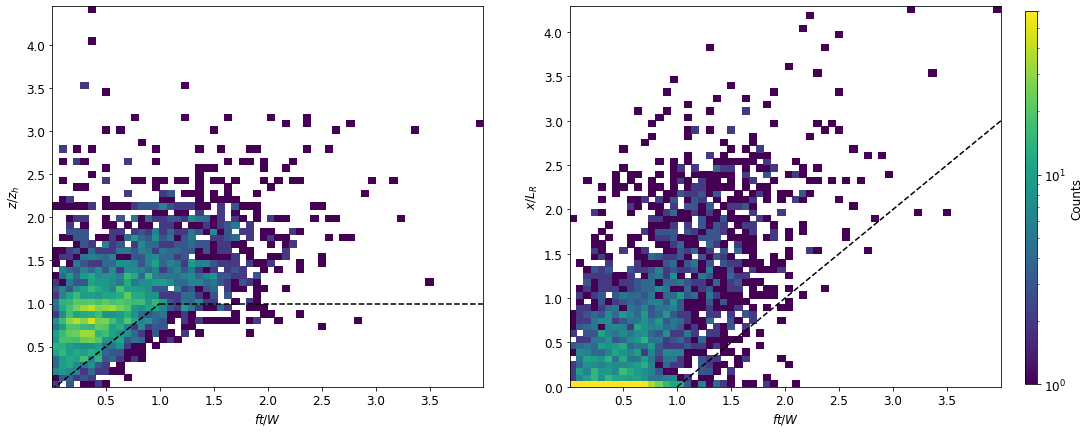

In [55]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cax = fig.add_axes([0.92, 0.13, 0.01, 0.74])
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)

# Loop through run parameters
x, y1, y2 = np.empty(0), np.empty(0), np.empty(0)
for date in events_southerly:
    dateobj = parse(date)
    datestr = dateobj.strftime('%Y%b%d')
            
    # Define upwelling predictor ft/W
    z_h = np.array(runs[datestr]['z_h'])
    g_prime = const['g'] * (const['rho_0'] - np.array(runs[datestr]['rho_s'])) / const['rho_0']
    L_R = np.sqrt(g_prime * z_h) / const['f']
    ftW = np.array(runs[datestr]['tau']) / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
    
    x = np.concatenate((x, ftW))
    y1 = np.concatenate((y1, np.array(runs[datestr]['z_u']) / z_h))
    y2 = np.concatenate((y2, np.array(runs[datestr]['x_u']) / L_R))

# Plot predictions vs results
for ax, y in zip(axs, [y1, y2]):
    _, _, _, c = ax.hist2d(x, y, norm=colors.LogNorm(vmin=1, vmax=60), bins=60)
    
fig.colorbar(c, cax=cax, label='Counts')

***

### Idealized - N constant

In [ ]:
# Paths, parameters and variable initialization
path = '/data/bmoorema/results/Lake/S4d_Nconst'
Nlist = np.arange(0.01, 0.026, 0.0025)
runs = {}

# Loop through run parameters and define dict fields
for N in tqdm(Nlist):
    runs[N] = {}
    for U in param['u_wind']:
        runs[N][U] = {'z_u': [], 'x_u': []}
        
        # Define and load results file
        runID = f'SalishSeaPond_S4d{U:02d}ms_N{Nval*1e4:04.0f}s'
        file = os.path.join(path, runID, fn)
        if os.path.exists(file):
            with xr.open_dataset(file) as data:

                # Loop through sections
                for i, j, a in zip(icoast, jindex, angle):

                    # Calculate upwelling metrics
                    z_u, x_u = calc_idealized_upwelling_metrics(
                        data, mask, hour, j, i, 10, jsub=grids['ideal'][2], isub=grids['ideal'][0], angle=a, L=L,
                    )
                    runs[N][U]['z_u'].append(z_u)
                    runs[N][U]['x_u'].append(x_u)

***

## Test postprocessing module

In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
from dateutil.parser import parse
from matplotlib import colors
import NEMO_upwelling_postprocessing as ps

%matplotlib inline

In [22]:
plt.rcParams['font.size'] = 12

In [3]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50

In [4]:
# Build coastline index arrays
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry)
sections = ps.calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS)

In [6]:
# Process idealized 2-layer results
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}
runs = ps.process_idealized_results_2layer(param, sections, mask, grids)

In [7]:
# Process hindcast results
runs = ps.process_hindcast_results(events_southerly, sections, mask, HRDPS)